In [1]:
import argparse
import json
import logging
import pathlib
import time
from copy import deepcopy

import numpy as np
import qibo

qibo.set_backend("numpy")
from qibo import hamiltonians
from qibo.backends import construct_backend
from qibo.quantum_info.metrics import fidelity

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.compiling_XXZ import *
from boostvqe.models.dbi import double_bracket_evolution_oracles
from boostvqe.models.dbi.double_bracket import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import (
    FrameShiftedEvolutionOracle,
    IsingNNEvolutionOracle,
    MagneticFieldEvolutionOracle,
    XXZ_EvolutionOracle,
)
from boostvqe.models.dbi.group_commutator_iteration_transpiler import (
    DoubleBracketRotationType,
    GroupCommutatorIterationWithEvolutionOracles,
)
from boostvqe.utils import (
    OPTIMIZATION_FILE,
    PARAMS_FILE,
    build_circuit,
    optimize_D,
    select_recursion_step_gd_circuit,
)

[Qibo 0.2.9|INFO|2024-07-15 14:44:36]: Using numpy backend on /CPU:0


In [2]:
nqubits = 5

# this is the Hamiltonian that we are studying
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=10, order=2
)


# Shifted oracle is passed to the group commutator
gci = GroupCommutatorIterationWithEvolutionOracles(
    base_oracle,
    DoubleBracketRotationType.group_commutator,
)

params = [4 - np.sin(x / 3) for x in range(nqubits)]
print(params)

eo_d_type = IsingNNEvolutionOracle
eo_d = eo_d_type.load([0]*5 + [.5]*5)

[4.0, 3.6728053032038477, 3.381630196930263, 3.1585290151921033, 3.0280620986366875]


In [3]:
h = hamiltonians.XXZ(5)
dbi = DoubleBracketIteration(h)
op1 = dbi.eval_dbr_unitary(step=0.1, mode=DoubleBracketGeneratorType.group_commutator)
op2 = gci._forward(0.1, eo_d, DoubleBracketRotationType.group_commutator).unitary()
print(np.linalg.norm(op1-op2))

3.374923447061855


In [4]:
from scipy.linalg import expm, sinm, cosm
op1 = expm(-0.1j*dbi.diagonal_h_matrix)
op2 = eo_d.circuit(0.1).unitary()
print(np.linalg.norm(op1-op2))

5.45663604615762e-16


In [5]:
op1 = expm(-0.5j*dbi.h.matrix)
op2 = base_oracle.circuit(0.5).unitary() * vw_xxz_compiling_phase(nqubits,steps=10, order = 2)
print(np.linalg.norm(op1-op2))

1.7325245111816059


In [6]:
np.linalg.norm(dbi.h.matrix - base_oracle.h.matrix)

[Qibo 0.2.9|WARNING|2024-07-15 14:44:39]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0.0

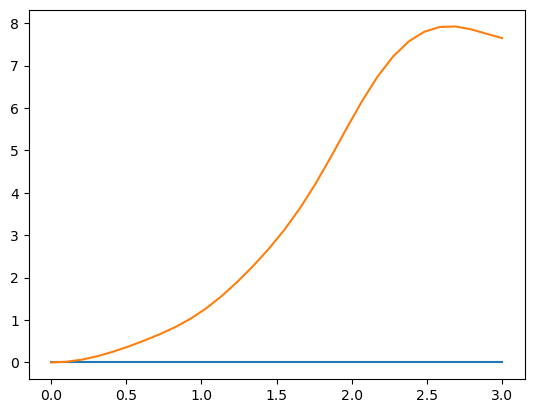

In [53]:

from qibo import hamiltonians
import numpy as np
from boostvqe.compiling_XXZ import *

t = 0.01
steps = 3
delta=0.5
nqubits= 5
order=1

h_xxz = hamiltonians.XXZ(nqubits=nqubits, delta = delta)
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=delta, steps=steps, order=1
)

diff_norms = []
diff_norms_2nd_order = []
times = np.linspace(0,3,30)
for t in times:
    u = h_xxz.exp(t)
    circ = nqubit_XXZ_decomposition(nqubits=nqubits,t=t,delta=delta,steps=steps, order=order)
    # diff_norms.append(np.linalg.norm(u-vw_xxz_compiling_phase(nqubits,steps)*circ.unitary()))
    diff_norms.append(np.linalg.norm(base_oracle.circuit(t, order=order, steps=steps).unitary()-circ.unitary()))
    circ = nqubit_XXZ_decomposition(nqubits=nqubits,t=t,delta=delta,steps=steps,order=2)
    diff_norms_2nd_order.append(np.linalg.norm(u-vw_xxz_compiling_phase(nqubits,steps, order = 2)*circ.unitary()))

import matplotlib.pyplot as plt

plt.plot(times, diff_norms)
plt.plot(times, diff_norms_2nd_order)

In [55]:
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=5, delta=0.5, steps=3, order=1
)
print(base_oracle.delta)
print(base_oracle.order)
print(base_oracle.steps)

base_oracle.circuit(t_duration=0.02,  ).unitary()

0.5
1
1


array([[-6.70882472e-01+7.41563691e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.81784007e-34+8.94811083e-35j, -1.56150725e-17+1.60850227e-17j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -6.98881073e-01+7.13000358e-01j,
         2.79477888e-02+2.85124096e-02j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -1.68988732e-17+1.47259647e-17j],
       [ 0.00000000e+00+0.00000000e+00j,  2.91121804e-02+2.74158312e-02j,
        -6.98881073e-01+7.13000358e-01j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         6.30612811e-19+6.37175200e-19j],
       ...,
       [-3.05710816e-19-2.83336904e-19j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
        -6.98881073e-01+7.13000358e-01j,  2.91121804e-02+2.74158312e-02j,
         0.00000000e+00+0.00000000e+00j],
       [ 7.42362162e-18-7.13113996e-18j,  0.

In [46]:
nqubit_XXZ_decomposition(
            nqubits=5,
            t=0.02,
            delta=0.5,
            steps=3,
            order=1,
        ).unitary()

array([[ 7.41563691e-01+6.70882472e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         4.66756029e-19-5.82627070e-19j, -1.11758416e-17-5.89724807e-18j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  7.13000223e-01+6.98880939e-01j,
         2.81590534e-02-2.83471848e-02j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         3.42595993e-17-3.27013878e-17j],
       [ 0.00000000e+00+0.00000000e+00j,  2.77933305e-02-2.87355206e-02j,
         7.13000223e-01+6.98880939e-01j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -1.24509192e-18-5.62373593e-19j],
       ...,
       [-8.40825251e-19+1.55110602e-18j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.13000223e-01+6.98880939e-01j,  2.77933305e-02-2.87355206e-02j,
         0.00000000e+00+0.00000000e+00j],
       [-3.52383552e-17-5.41573240e-18j,  0.

In [10]:
eo_d.h.circuit(0.05).unitary()

array([[0.99219767-0.12467473j, 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99968752-0.0249974j ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.99968752-0.0249974j , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       ...,
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.99968752-0.0249974j ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.99968752-0.0249974j , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
 

In [11]:
from qibo import Circuit
c = Circuit(nqubits=5)
c2 = gci._forward(0.1, eo_d, DoubleBracketRotationType.group_commutator)
base_oracle.h.expectation(c2().state())

2.499999999999999

In [12]:
s_space = np.linspace(1e-3, 0.5, 100)
modes = [
    DoubleBracketRotationType.group_commutator,
    DoubleBracketRotationType.group_commutator_third_order,
]
plots = []

In [13]:
for mode in modes:
    plots.append([gci.loss(step_duration=s, d=eo_d, mode=mode) for s in s_space])

In [14]:
import matplotlib.pyplot as plt

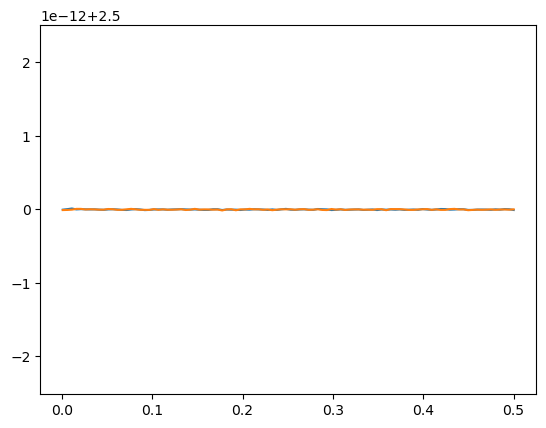

In [15]:
for i, mode in enumerate(modes):
    plt.plot(s_space, plots[i], label=mode)
    

In [16]:
gci.loss(step_duration=0.5, d=eo_d, mode=DoubleBracketRotationType.group_commutator)

2.499999999999992

In [17]:
gci.loss(step_duration=0.1, d=eo_d, mode=DoubleBracketRotationType.group_commutator_third_order)

2.4999999999999964

In [18]:

    
        

    else:
        if gci_step_nmb == 0:
            p0 = [0.01]
            if eo_d_type == MagneticFieldEvolutionOracle:
                p0.extend([4 - np.sin(x / 3) for x in range(nqubits)])
            elif eo_d_type == IsingNNEvolutionOracle:
                p0.extend(
                    [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
                )

        else:
            p0 = [best_s]
            p0.extend(best_b)
        optimized_params, opt_dict = optimize_D(
            params=p0,
            gci=gci,
            eo_d_type=eo_d_type,
            mode=args.db_rotation,
            method=args.optimization_method,
            **opt_options,
        )
        best_s = optimized_params[0]
        best_b = optimized_params[1:]
        eo_d = eo_d_type.load(best_b)

    step_data = dict(
        best_s=best_s,
        eo_d_name=eo_d.__class__.__name__,
        eo_d_params=eo_d.params,
    )
    logging.info(f"Total optimization time required: {time.time() - it} seconds")
    gci.mode_double_bracket_rotation = args.db_rotation

    gci(best_s, eo_d, args.db_rotation)

    this_report = report(vqe, hamiltonian, gci, best_s, eo_d, args.db_rotation)
    print_report(this_report)
    metadata[gci_step_nmb + 1] = this_report | step_data | opt_dict

(dump_path / "boosting_data.json").write_text(json.dumps(metadata, indent=4))

SyntaxError: invalid syntax (1664433500.py, line 1)